Data Generator

In [ ]:
import numpy as np
import pandas as pd
import os, zipfile
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
from tqdm import tqdm, tqdm_notebook
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [ ]:
#data_dir_name = "./data"
zip_dir_name = "/content/t20s_male.zip"
zip_ref = zipfile.ZipFile(zip_dir_name, "r")
filenames = list(map(lambda x:x.filename, zip_ref.filelist))

team_match_cnt = {}
#Create a dataframe with (filaname, date)
file_info_list=[]
for filename in tqdm(filenames):
    if filename.endswith(".yaml"):
        with zip_ref.open(filename, 'r') as stream:
            data_loaded = yaml.load(stream, Loader=yaml.SafeLoader) #gave safe loader as an argument.
            #exclude draw matches and D/L
            if 'result' in list(data_loaded['info']['outcome'].keys()) or 'method' in list(data_loaded['info']['outcome'].keys()):
                continue
            date = data_loaded['info']['dates'][0]
            teamBatting = data_loaded['innings'][1]['2nd innings']['team']
            teamBowling = data_loaded['innings'][0]['1st innings']['team']
            if teamBatting not in team_match_cnt:
                team_match_cnt[teamBatting] = 0
            if teamBowling not in team_match_cnt:
                team_match_cnt[teamBowling] = 0
            team_match_cnt[teamBatting] += 1
            team_match_cnt[teamBowling] += 1

            row = (filename, date, teamBatting, teamBowling)
            file_info_list.append(row)
file_info_list = [dict(zip(['filename','date'], [filename, date])) for filename,date,teamBatting,teamBowling in file_info_list
                if (team_match_cnt[teamBatting]>5 and team_match_cnt[teamBowling] > 5)]
file_df = pd.DataFrame(file_info_list)
file_df['date'] = pd.to_datetime(file_df['date'])
file_df.sort_values(by=['date'], inplace=True)

train_file_df, val_file_df =  train_test_split(file_df, test_size=0.2, shuffle=False)
val_file_df, test_file_df = train_test_split(val_file_df, test_size=0.5, shuffle=False)


cols = ['team-batting', 'team-bowling', 'wicket-left', 'runs-scored', 'target-score', 'balls-bowled',
        'batsman-score', 'nonstriker-score', 'batsman-balls-faced', 'nonstriker-balls-faced',
        'match-id', 'winner', 'date']

def getRow(data_loaded, matchId, filename):
    match_data = []

    date = pd.to_datetime(data_loaded['info']['dates'][0])
    targetScore, runsScored, wicketLeft = 0, 0, 10
    ballsBowled = 0
    playerRuns = {}
    teamBatting = data_loaded['innings'][1]['2nd innings']['team']
    teamBowling = data_loaded['innings'][0]['1st innings']['team']
    for x in data_loaded['innings'][0]['1st innings']['deliveries']:
        targetScore += x[list(x.keys())[0]]['runs']['total']
    winner = data_loaded['info']['outcome']['winner']
    push = True

    for x in (data_loaded['innings'][1]['2nd innings']['deliveries']):
        #Update Batsman Score
        key = list(x.keys())[0]
        striker = x[key]['batsman']
        nonStriker = x[key]['non_striker']
        if(striker not in playerRuns):
            playerRuns[striker] = [0, 0]     #[ballsPlayed, runsScore]
        if(nonStriker not in playerRuns):
            playerRuns[nonStriker] = [0, 0]

        values = [teamBatting, teamBowling, wicketLeft, runsScored, targetScore, ballsBowled,
                   playerRuns[striker][1], playerRuns[nonStriker][1],
                   playerRuns[striker][0], playerRuns[nonStriker][0],
                   matchId, winner, date]
        if push: match_data.append(dict(zip(cols, values)))
        else: match_data[-1] = dict(zip(cols, values))

        wicketLeft -= int('wicket' in x[key])
        runsScored += x[key]['runs']['total']
        playerRuns[striker][1] += x[key]['runs']['batsman']

        #If this ball is not wide or no ball then increment ballsPlayed
        if 'extras' not in x[key]:
            playerRuns[striker][0] += 1
            ballsBowled += 1
            push = True
        elif 'legbyes' in x[key]['extras'] or 'byes' in x[key]['extras']:
            ballsBowled += 1
            push = True
        else: push = False

    return match_data

# Get train, validation and test dataframes
matchId = 0
train_data, val_data, test_data = [], [], []
for filename in tqdm(train_file_df.loc[:, 'filename']):
    with zip_ref.open(filename, 'r') as stream:
        data_loaded = yaml.load(stream, Loader=yaml.SafeLoader)
        match_data = getRow(data_loaded, matchId, filename)
        matchId+=1
        stream, data_loaded = None, None
        train_data += match_data

for filename in tqdm(val_file_df.loc[:, 'filename']):
    with zip_ref.open(filename, 'r') as stream:
        data_loaded = yaml.load(stream, Loader=yaml.SafeLoader)
        match_data = getRow(data_loaded, matchId, filename)
        matchId+=1
        stream, data_loaded = None, None
        val_data += match_data

for filename in tqdm(test_file_df.loc[:, 'filename']):
    with zip_ref.open(filename, 'r') as stream:
        data_loaded = yaml.load(stream, Loader=yaml.SafeLoader)
        match_data = getRow(data_loaded, matchId, filename)
        matchId+=1
        stream, data_loaded = None, None
        test_data += match_data

#pd.DataFrame(train_data).to_csv("./data/train_data.csv")
pd.DataFrame(train_data).to_csv("/content/train_data.csv")
pd.DataFrame(val_data).to_csv("/content/val_data.csv")
pd.DataFrame(test_data).to_csv("/content/test_data.csv")

100%|██████████| 85/85 [00:28<00:00,  2.96it/s]


Pre Processing

In [ ]:
class PreprocessingHelper:
    feature_cols = ['team-batting', 'team-bowling', 'wicket-left', 'runs-scored', 'target-score', 'balls-bowled',
                'batsman-score', 'nonstriker-score', 'batsman-balls-faced', 'nonstriker-balls-faced']
    max_sequence_length = 120

    def __init__(self):
        train_df = pd.read_csv("/content/train_data.csv", index_col = 0)
        val_df = pd.read_csv("/content/val_data.csv", index_col = 0)
        test_df = pd.read_csv("/content/test_data.csv", index_col = 0)

        self.le = LabelEncoder()
        x = train_df['team-batting'].tolist() + train_df['team-bowling'].tolist()
        x = x + val_df['team-batting'].tolist() + val_df['team-bowling'].tolist()
        x = x + test_df['team-batting'].tolist() + test_df['team-bowling'].tolist()
        self.le.fit(x)

        train_df = self.encodedLabels(train_df)
        train_df['balls-left'] = 120 - train_df['balls-bowled']
        # train_df['runs-req'] = train_df['target-score'] - train_df['runs-scored']
        train_df = train_df.loc[train_df['balls-left']>0, :]
        self.std = np.std(train_df.loc[:, self.feature_cols[2:]], axis = 0)
        self.mean = np.mean(train_df.loc[:, self.feature_cols[2:]], axis = 0)

    def getLabelEncoding(self, x):
        return self.le.transform(x) + 1

    def encodedLabels(self, df):
        df.loc[:, 'team-batting'] = self.getLabelEncoding(df['team-batting'])
        df.loc[:, 'team-bowling'] = self.getLabelEncoding(df['team-bowling'])
        df.loc[:, 'winner'] = self.getLabelEncoding(df['winner'])

        return df

    def normalize(self, df):
        df.loc[:, self.feature_cols[2:]] = (df.loc[:, self.feature_cols[2:]] - self.mean) / self.std
        return df

    def getPredictionLabel(self, df):
        boolmap = (df.winner == df['team-batting'])
        df.loc[:, 'prediction'] = np.array(boolmap).astype(float) #changed to float from np.float
        return df

    def getX_Y(self, df):
        n, m = df.agg({'match-id':'nunique'})[0], len(self.feature_cols)
        X, Y = np.zeros((n, self.max_sequence_length, m)), np.zeros((n, self.max_sequence_length, 1))
        grouped = df.groupby(['match-id'])
        i = 0
        for group_name, group in tqdm(grouped):
            j = 0
            for row_index, row in group.iterrows():
                if j<self.max_sequence_length:
                    Y[i, j, 0] = row['prediction']
                    X[i, j, :] = row[self.feature_cols].values
                j = j + 1
            i = i + 1
        return X, Y

    def preprocess(self, df):
        df.loc[:, 'balls-left'] = 120 - df['balls-bowled']
        # df['runs-req'] = df['target-score'] - df['runs-scored']
        df = df.drop(df.loc[df['balls-left']<=0].index)
        df = self.getPredictionLabel(df)
        df_c = df.copy()
        df = self.encodedLabels(df)
        df = self.normalize(df)

        return df, df_c

Model

In [ ]:
from tensorflow.keras.layers import *
from tensorflow.keras import *
from tensorflow.keras.optimizers import *

In [ ]:
def get_model(preprocessingHelper):
    VOCABULARY_SIZE = len(preprocessingHelper.le.classes_) + 1
    output_dim = 2

    input = Input(shape=(preprocessingHelper.max_sequence_length, len(preprocessingHelper.feature_cols)))
    M1 = Masking(mask_value=0.0, input_shape=(preprocessingHelper.max_sequence_length, len(preprocessingHelper.feature_cols)))(input)

    E1 = Embedding(input_dim=VOCABULARY_SIZE, output_dim=output_dim, trainable=True, input_length=preprocessingHelper.max_sequence_length)(M1[:, :, 0])
    E2 = Embedding(input_dim=VOCABULARY_SIZE, output_dim=output_dim, trainable=True, input_length=preprocessingHelper.max_sequence_length)(M1[:, :, 1])

    C1 = Concatenate()([E1, E2, M1[:, :, 2:]])
    L1 = LSTM(64, return_sequences=True)(C1)
    output = Dense(1, activation='sigmoid')(L1)
    lstm_model = Model(inputs=input, outputs=output)
    lstm_model.compile(optimizer= RMSprop(learning_rate=5e-4), loss='binary_crossentropy', metrics=['acc'])

    return lstm_model

Train

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Masking
from scipy.interpolate import make_interp_spline
from scipy.ndimage.filters import gaussian_filter1d
import matplotlib.pyplot as plt

<ipython-input-10-cd6e3ea8f863>:4: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d


100%|██████████| 85/85 [00:05<00:00, 16.43it/s]


Epoch 1/50
11/11 [==============================] - ETA: 0s - loss: 0.6388 - acc: 0.6670
Epoch 1: val_acc improved from -inf to 0.76539, saving model to ./weights.best.hdf5
11/11 [==============================] - 5s 226ms/step - loss: 0.6388 - acc: 0.6670 - val_loss: 0.5723 - val_acc: 0.7654
Epoch 2/50
 1/11 [=>............................] - ETA: 0s - loss: 0.5984 - acc: 0.7229

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - ETA: 0s - loss: 0.5685 - acc: 0.7346
Epoch 2: val_acc improved from 0.76539 to 0.77706, saving model to ./weights.best.hdf5
11/11 [==============================] - 1s 93ms/step - loss: 0.5685 - acc: 0.7346 - val_loss: 0.5015 - val_acc: 0.7771
Epoch 3/50
11/11 [==============================] - ETA: 0s - loss: 0.5181 - acc: 0.7501
Epoch 3: val_acc improved from 0.77706 to 0.78961, saving model to ./weights.best.hdf5
11/11 [==============================] - 1s 93ms/step - loss: 0.5181 - acc: 0.7501 - val_loss: 0.4506 - val_acc: 0.7896
Epoch 4/50
11/11 [==============================] - ETA: 0s - loss: 0.4915 - acc: 0.7607
Epoch 4: val_acc improved from 0.78961 to 0.79902, saving model to ./weights.best.hdf5
11/11 [==============================] - 1s 97ms/step - loss: 0.4915 - acc: 0.7607 - val_loss: 0.4326 - val_acc: 0.7990
Epoch 5/50
11/11 [==============================] - ETA: 0s - loss: 0.4747 - acc: 0.7729
Epoch 5: val_acc improved from 0.7

100%|██████████| 85/85 [00:05<00:00, 15.79it/s]


2/2 [==============================] - 0s 20ms/step


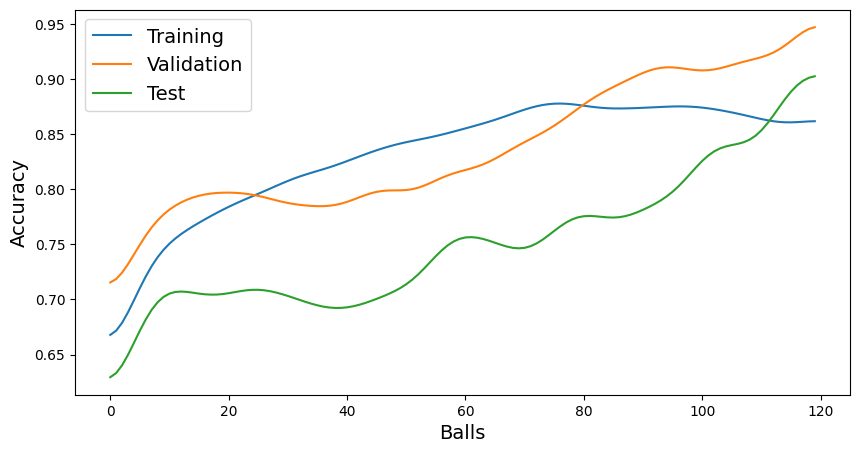

In [ ]:
preprocessingHelper = PreprocessingHelper()
#train_df = pd.read_csv("./data/train_data.csv", index_col = 0)
train_df = pd.read_csv("/content/train_data.csv", index_col = 0)
#val_df = pd.read_csv("./data/val_data.csv", index_col = 0)
val_df = pd.read_csv("/content/val_data.csv", index_col = 0)
train_df, train_df_c = preprocessingHelper.preprocess(train_df)
val_df, val_df_c = preprocessingHelper.preprocess(val_df)
X_train, Y_train = preprocessingHelper.getX_Y(train_df)
X_val, Y_val = preprocessingHelper.getX_Y(val_df)

lstm_model = get_model(preprocessingHelper)

filepath="./weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = lstm_model.fit(X_train, Y_train, validation_data = (X_val, Y_val),
            batch_size=64, verbose=1, epochs=50, shuffle=True, callbacks = callbacks_list)

# Plot Results
lstm_model.load_weights("./weights.best.hdf5")
test_df = pd.read_csv("/content/test_data.csv", index_col = 0)
test_df, test_df_c = preprocessingHelper.preprocess(test_df)
X_test, Y_test = preprocessingHelper.getX_Y(test_df)

def getAcc(X, Y):
    pred_y = lstm_model.predict(X, batch_size = 64)
    pred_y = pred_y.reshape(pred_y.shape[0], -1)
    Y_t = Y.reshape(Y.shape[0], -1)
    masking = Masking(mask_value=0.0, input_shape=(preprocessingHelper.max_sequence_length, len(preprocessingHelper.feature_cols)))
    mask = (masking(X)._keras_mask.numpy()).reshape(pred_y.shape).astype(float)
    pred_y = (pred_y >= 0.5).astype(float)
    acc = np.sum((Y_t == pred_y)*mask, axis = 0)/np.sum(mask, axis = 0)

    return acc

train_acc = getAcc(X_train, Y_train)
val_acc = getAcc(X_val, Y_val)
test_acc = getAcc(X_test, Y_test)

x = np.arange(120)
test_acc_new = gaussian_filter1d(test_acc, sigma=4)
train_acc_new = gaussian_filter1d(train_acc, sigma=4)
val_acc_new = gaussian_filter1d(val_acc, sigma=4)

fig, ax = plt.subplots()
fig.set_size_inches((10, 5))
ax.plot(x, train_acc_new, label = 'Training', )
ax.plot(x, val_acc_new, label = 'Validation',)
ax.plot(x, test_acc_new, label = 'Test',)
color = '#000000'
ax.set_ylabel("Accuracy", fontsize=14, color = color)
ax.set_xlabel("Balls", fontsize=14, color = color)
ax.tick_params(axis='x', colors=color)
ax.tick_params(axis='y', colors=color)
ax.spines['bottom'].set_color(color)
ax.spines['top'].set_color(color)
ax.spines['left'].set_color(color)
ax.spines['right'].set_color(color)
ax.set_facecolor((0.0, 0.0, 0.0, 0.0))
ax.legend(fontsize=14)
plt.savefig("/content/acc.png")

Simulation

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
import sys

In [ ]:
def get_test_match_id():
    test_df = pd.read_csv("/content/test_data.csv", index_col = 0)
    print(np.unique(test_df['match-id']))

def simulate(match_id):
    test_df = pd.read_csv("/content/test_data.csv", index_col = 0)
    preprocessingHelper = PreprocessingHelper()
    test_df, test_df_c = preprocessingHelper.preprocess(test_df)

    match_df = (test_df[test_df['match-id'] == match_id]).reset_index()
    match_df_c = (test_df_c[test_df_c['match-id'] == match_id]).reset_index()
    X, Y = preprocessingHelper.getX_Y(match_df)

    battingTeam = match_df_c.loc[0, 'team-batting']
    bowlingTeam = match_df_c.loc[0, 'team-bowling']
    winner = match_df_c.loc[0, 'winner']
    target = match_df_c['target-score'][0]
    print("Simulating: {}(Batting) vs {}(Bowling)\n Target: {} \n Winner: {}".format(
        battingTeam, bowlingTeam, target, winner))
    print("Date: {}".format(match_df_c['date'][0]))

    lstm_model = get_model(preprocessingHelper)
    lstm_model.load_weights("weights.best.hdf5")
    p = lstm_model.predict(X)
    p_l = p.flatten().tolist()

    match = match_df_c
    fig=plt.figure(figsize=(12, 5))
    fig.suptitle(battingTeam + " vs " + bowlingTeam + ": " + str(match['date'][0]) +
                 " | " + "Winner: " + winner + "\n",
                 fontsize=16, y=1.08)

    ax_1=fig.add_subplot(1,3,1)
    wicket_l = (10-match['wicket-left'].values.flatten()).tolist()
    runsScored_l = match['runs-scored'].values.flatten().tolist()
    overs_l = [str(x // 6)+"." + str(x%6) for x in match['balls-bowled'].values.flatten().tolist()]
    ax_1.axes.get_yaxis().set_visible(False)
    ax_1.axes.get_xaxis().set_visible(False)
    ax_1.set_frame_on(False)
    txt= ax_1.text(0.1, 0.5,'Run-Wickets | Overs', horizontalalignment='left',verticalalignment='center',transform = ax_1.transAxes, fontsize=14,
                 bbox=dict(facecolor='white', edgecolor='white'))
    txt.set_clip_on(False)

    ax_2=fig.add_subplot(1,3,2)
    barcollection_2 = ax_2.bar([battingTeam, bowlingTeam], [p_l[0], 1.0 - p_l[0]])
    ax_2.set_ylim([0, 1.0])
    ax_2.set_ylabel("Probability", fontsize=14)
    ax_2.set_frame_on(False)

    ax_3=fig.add_subplot(1,3,3)
    reqRunRate_l = ((match['target-score'] - match['runs-scored'])/(120 - match['balls-bowled'])).values.tolist()
    currRunRate_l = (match['runs-scored']/(match['balls-bowled']+1.0)).values.tolist()
    barcollection_3 = ax_3.bar(["RRR", "CRR"], [reqRunRate_l[0]*6, currRunRate_l[0]*6])
    ax_3.set_ylim([0, 36])
    ax_3.set_ylabel("Runs", fontsize=14)
    ax_3.set_frame_on(False)
    plt.tight_layout()

    def animate(i):
        print("Animating frame", i) #animate check
        s = "Target: " + str(target) + "\n" + battingTeam + ": " + str(runsScored_l[i]) + "-" + str(wicket_l[i]) + " | " + overs_l[i]
        txt.set_text(s)
        h_2 = [p_l[i], 1-p_l[i]]
        h_3 = [reqRunRate_l[i]*6, currRunRate_l[i]*6]
        for i, b in enumerate(barcollection_2):
            b.set_height(h_2[i])
        for i, b in enumerate(barcollection_3):
            b.set_height(h_3[i])

    anim=animation.FuncAnimation(fig, animate, repeat=False, blit=False,frames=len(wicket_l),
                                 interval=1000)
    anim.save("/content/simulate"+str(match_id)+".mp4",writer=animation.FFMpegWriter(fps=2))

arg = sys.argv[1]
if arg == 'simulate':
    match_id = int(sys.argv[2])
    simulate(match_id)

elif arg == 'getid':
    get_test_match_id()